# Singular Value Decomposition (SVD)

Let's see how SVD can be used to reduce the size of your data, an image in this case, without losing out on much of the quality or information.

We start by loading an image in grayscale.

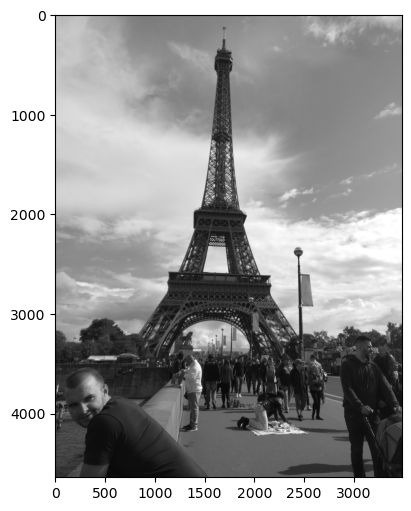

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('eiffel_2.jpg')
imggray = img.convert('LA')
plt.figure(figsize = (8, 6))
plt.imshow(imggray)

`Say hello to my friend Ansgar Graf ☝`



Next, we converting it into a numpy matrix to make it easy to manipulate with numpy methods.

In [2]:
imgmat = np.array(list(imggray.getdata(band = 0)), float)
imgmat.shape = (imggray.size[1], imggray.size[0])
imgmat = np.matrix(imgmat)

We can use the `numpy.linalg.svd()` method on the image matrix to get the SVD.


*   `U` is the matrix containing the left singular vectors
*   `V` is the matrix containing the right singular vectors
*   `sigma` is the vector containing the singular values from the diagnoal matrix `Σ` in descending order



In [3]:
U, sigma, V = np.linalg.svd(imgmat)

In [4]:
print(f"We have {sigma.shape[0]} singular values.")
print(f"U is of size {U.shape}.")
print(f"V is of size {V.shape}.")
print(f"The last, or smallest entry in sigma is {sigma[-1]}")

We have 3480 singular values.
U is of size (4640, 4640).
V is of size (3480, 3480).
The last, or smallest entry in sigma is 6.294002175999893


Let's try reconstructing the image using only the first (most powerful) singular value.

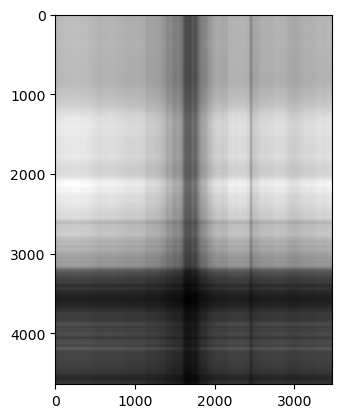

In [5]:
reconstimg = np.matrix(U[:, :1]) * np.diag(sigma[:1]) * np.matrix(V[:1, :])
plt.imshow(reconstimg, cmap = 'gray')

We can also check the explained variances by each singular value as a proportion.

C:\Users\hp\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


variance Explained by Top 20 singular values:
[9.09533e-01 3.27300e-02 1.72890e-02 1.04930e-02 3.45100e-03 3.20200e-03
 2.53200e-03 2.35000e-03 1.82500e-03 1.30300e-03 8.89000e-04 7.90000e-04
 6.84000e-04 6.33000e-04 5.57000e-04 5.13000e-04 4.75000e-04 3.90000e-04
 3.37000e-04 3.36000e-04]



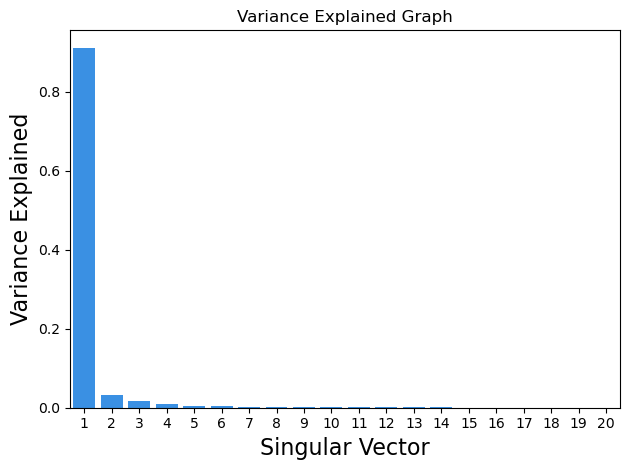

In [6]:
import seaborn as sns

var_explained = np.round(sigma**2/np.sum(sigma**2), decimals=6)

# Variance explained top singular values
print(f'variance Explained by Top 20 singular values:\n{var_explained[0:20]}\n')

sns.barplot(x = list(range(1, 21)), y = var_explained[0:20], color = "dodgerblue")

plt.title('Variance Explained Graph')
plt.xlabel('Singular Vector', fontsize = 16)
plt.ylabel('Variance Explained', fontsize = 16)
plt.tight_layout()
plt.show()

Let's see how much of the image we get back by only plotting the first 10 singular values.

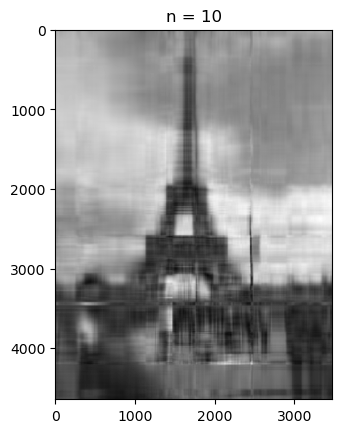


explained variance: 0.9847


In [7]:
i = 10
reconstimg = np.matrix(U[:, :i]) * np.diag(sigma[:i]) * np.matrix(V[:i, :])
plt.imshow(reconstimg, cmap = 'gray')
plt.title(f"n = {i}")
plt.show()

print(f"\nexplained variance: {round(sum(var_explained[:i]), 4)}")

We can find how many components we need to get an explained variance of 99.9%

In [8]:
thresh = 0.999
n = 1

while sum(var_explained[:n]) < thresh:
    n += 1

print(n)
sum(var_explained[:n])

214


0.9990039999999999

How does the explained variance change as the number of retained components or singular values increases?

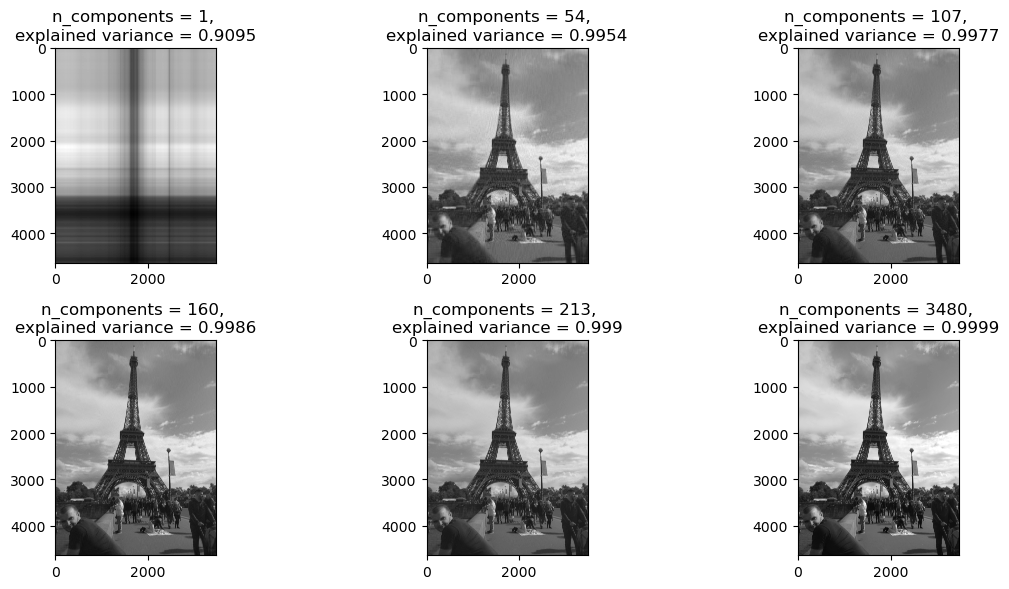

In [9]:
# plot images with different number of components
comps = list(range(1, n, n//4)) + [sigma.shape[0]]
plt.figure(figsize=(12, 6))

for i in range(len(comps)):
    reconstimg = np.matrix(U[:, :comps[i]]) * np.diag(sigma[:comps[i]]) * np.matrix(V[:comps[i], :])

    plt.subplot(2, 3, i + 1),
    plt.imshow(reconstimg, cmap = 'gray'),
    plt.title(f'n_components = {comps[i]}, \nexplained variance = {round(sum(var_explained[:comps[i]]), 4)}')

plt.tight_layout()

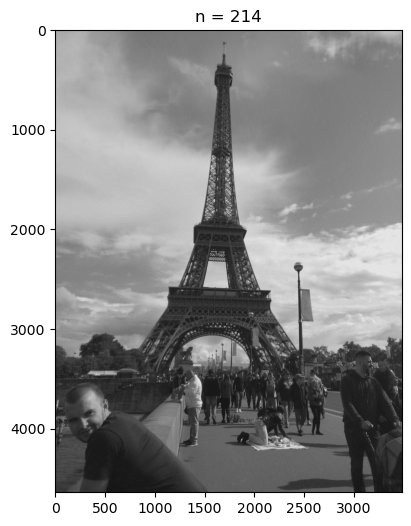


For this quality, we have to store 359734 numbers, compared to the original 5849880. 
Space saved 93.85%


In [10]:
i = n
reconstimg = np.matrix(U[:, :i]) * np.diag(sigma[:i]) * np.matrix(V[:i, :])
plt.figure(figsize = (8, 6))
plt.imshow(reconstimg, cmap = 'gray')
plt.title(f"n = {i}")
plt.show()

numbers = 960*i + i + 720*i
original = 960*sigma.shape[0] + sigma.shape[0] + 720*sigma.shape[0]
print(f"\nFor this quality, we have to store {numbers} numbers, compared to the original {original}. \nSpace saved {round(100*(original - numbers)/original, 2)}%")


# Revealing hidden message in a picture using SVD

### Load the pictureand display

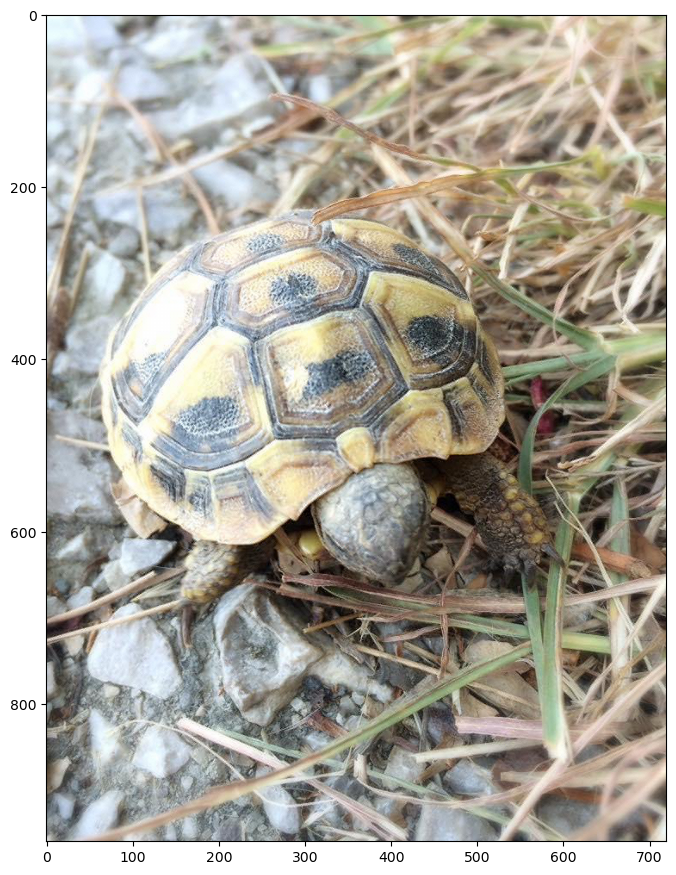

In [11]:
img = Image.open('hidden_message.png')
plt.figure(figsize = (8, 12))
plt.imshow(img)

### Converting to numpy and listing shape

In [12]:
img_array = np.array(img)
img_array.shape

(960, 720, 3)

### Divide the image into 3 color images

In [13]:
img_array_1 = img_array[:,:,0]
img_array_1 = img_array_1 / max(img_array_1.max(axis=1))
img_array_2 = img_array[:,:,1]
img_array_2 = img_array_2 / max(img_array_2.max(axis=1))
img_array_3 = img_array[:,:,2]
img_array_3 = img_array_3 / max(img_array_3.max(axis=1))

### For each image channel iterate through 4x4 blocks to get pixel values via SVD

In [14]:
row = 0
hidden_img = np.zeros(shape=(240, 180, 3))
hidden_img_row = 0
while row < img_array.shape[0]:
    col = 0
    hidden_img_col = 0
    while col < img_array.shape[1]:
        c = [0, 0, 0]
        tmp_img_1 = img_array_1[row:row+4, col:col+4]
        tmp_img_2 = img_array_2[row:row+4, col:col+4]
        tmp_img_3 = img_array_3[row:row+4, col:col+4]
        _, sigma1, _ = np.linalg.svd(tmp_img_1)
        _, sigma2, _ = np.linalg.svd(tmp_img_2)
        _, sigma3, _ = np.linalg.svd(tmp_img_3)
        if (sigma1[1] - sigma1[2]) > 0.004:
            c[0] = 1
        else:
            c[0] = 0
        if (sigma2[1] - sigma2[2]) > 0.004:
            c[1] = 1
        else:
            c[1] = 0
        if (sigma3[1] - sigma3[2]) > 0.004:
            c[2] = 1
        else:
            c[2] = 0
        hidden_img[hidden_img_row, hidden_img_col, 0], hidden_img[hidden_img_row, hidden_img_col, 1], hidden_img[hidden_img_row, hidden_img_col, 2] = c
        hidden_img_col += 1
        col += 4
    hidden_img_row += 1
    row += 4

In [15]:
hidden_img.shape

(240, 180, 3)

### Sum the channel values and display the image

In [16]:
sample_img = hidden_img.sum(axis=2)
sample_img = sample_img / max(sample_img.max(axis=1))
print(sample_img)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


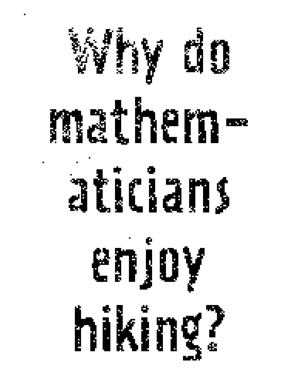

In [17]:
sample_img_bytes = (sample_img * 255).astype(np.uint8).tobytes()
sample_img = Image.frombytes('L', sample_img.T.shape, sample_img_bytes)
plt.imshow(sample_img, cmap='gray')
plt.axis('off')
plt.show()

## Because it keeps them away from theorems.

# More?

Explore image denoising using SVD: https://github.com/chr1shr/am205_g_activities/blob/master/svd_image_processing/image_denoising.ipynb